# Quantum Hamming Decoding
This file demonstrates the algorithm explained in our paper **"Quantum Channel Decoding"** as submitted to the [QEC-22 conference](https://qce.quantum.ieee.org/2022/).

Please refer to the readme file in the root of this repo for more information about setting up the environment, installing the required packages, and getting ready to run this notebook.

Copyright &copy; 2022 InterDigital AI Research Lab

In [1]:
import numpy as np
from qiskit.visualization import plot_histogram

from quantumhammingdecoder import QuantumHamming

## Creating a QuantumHamming class
Here we first create a ``QuantumHamming`` class for (7,4) Hamming Decoding, which means we are using 4-bit messages embedded in 7-bit code-words. The ``getRandomMessage`` method creates a random message and returns it together with the corresponding code-word, BPSK-modulated signal, and noisy received signal. 

Then we print the message information before calling a series of decoding functions to decode the noisy received signal using **Hard Decision**, **Maximum Likelihood**, and **Quantum** algorithms.

For a more realistic experience, you can use the ``FakeMontreal`` simulator which uses a noise model generated based on a real quantum computer (in this case IBMQ's "Montreal" quantum computer with 27 qubits).

In [2]:
# Instantiate a QuantumPolar class

# qh = QuantumHamming(7, simulator="FakeMontreal")  # Run on a simulated noisy quantum computer (IBMQ-Montreal)
qh = QuantumHamming(7)                              # Run on a simulated ideal quantum computer (aer_simulator)

ebNoDb = 2
# Create a random message (msg), and the corresponding codeWord, BPSK transmitted signal (tx), noisy
# received signal (rx), and the noise power based on the given Eb/N0 value (sigma2).
msg, codeWord, tx, rx, sigma2 = qh.getRandomMessage(ebNoDb)
print("Message:       ", "  ".join("%4d"%(x) for x in msg))
print("codeWord:      ", "  ".join("%4d"%(x) for x in codeWord))
print("Noisy Rx:       ", "  ".join("%4.1f"%(x) for x in rx))
cwHat = np.int8(rx<0)
print("Hard-Decision: ","  ".join("%4d"%(x) for x in cwHat))
print("Num bit errors:", sum((cwh!=cw) for cwh, cw in zip(cwHat,codeWord)), "(Hard Decision)")

print("\nDecoding with different algorithms:")
print("  Org. Message:                          ", "  ".join("%1d"%(x) for x in msg))

# Decode the received signal rx to get the original message:
# Using Hard Decision. The parity bits are used to do error correction.
msgHat = qh.hardDecode(rx, minDist=False)
print("  Decoded Message(Hard-Error Correction):", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

# Using Hard Decision and selecting based on minimum hamming distance
msgHat = qh.hardDecode(rx)
print("  Decoded Message(Hard-MinDist):         ", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

# Using Soft Decision and Maximum Likelihood based on maximum correlation between rx and all possible codewords
msgHat = qh.softDecode(rx)
print("  Decoded Message(Maximum Likelihood):   ", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

# Using Quantum Fast decoding (based on the highest count)
msgHat = qh.decodeFast(rx)
print("  Decoded Message(Quantum-Fast):         ", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

# Using Quantum plus ML:
msgHat = qh.decode(rx)
print("  Decoded Message(Quantum):              ", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

# Using Quantum plus ML plus Error Correction:
msgHat = qh.decode(rx, correctErrors=True)
print("  Decoded Message(Quantum+Correction):   ", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")


Message:           1     0     0     1
codeWord:          0     0     1     1     0     0     1
Noisy Rx:        -0.4   0.6  -1.4   0.2   0.6   1.6  -0.1
Hard-Decision:     1     0     1     0     0     0     1
Num bit errors: 2 (Hard Decision)

Decoding with different algorithms:
  Org. Message:                           1  0  0  1
  Decoded Message(Hard-Error Correction): 1  1  0  1 X
  Decoded Message(Hard-MinDist):          1  1  0  1 X
  Decoded Message(Maximum Likelihood):    1  0  0  1 ✓
  Decoded Message(Quantum-Fast):          1  1  0  1 X
  Decoded Message(Quantum):               1  0  0  1 ✓
  Decoded Message(Quantum+Correction):    1  0  0  1 ✓


## The quantum results statistics after executing the circuit
Now we print the bitstreams with highest "counts" and draw a histogram based on the counts. Here is an explanation of the columns:
- Qubits: The measured Qubits at the output of the quantum circuit
- Count: The number of times the bit-stream in ``Qubits`` was measured at the output of quantum circuit
- MSG: The message extracted from the qubits using message bit indexes
- Code-Word: The code-word obtained by applying the generator matrix G to the ``MSG``
- Correlation: The correlation between ``Code-Word`` and the noisy received signal
- Check: The ``n-k`` parity check bits. Zero means no error, otherwise shows the location of error.
- CW (rx): The code-word based on the received signal. May not be a valid code-word due to noise.
- CW (cor): The corrected code-word obtained from applying ``Check`` to ``CW (rx)``.
- MSG (cor): The corrected message extracted ``CW (cor)``
- Corrl (cor): The correlation between ``CW (cor)`` and the noisy received signal


Top-10 Candidates:
    Qubits   Count  MSG   Code-Word  Correlation  Check  CW (rx)  CW (cor)  MSG (cor)  Corrl (cor)
    PPMPMMM               CCMCMMM                        CCMCMMM  CCMCMMM                         
    1011001  318    1001  0011001    3.6681       101    1010001  1010101   1101       3.6592       ✓-
    0110000  170    1000  1110000    3.4451       010    1010000  1110000   1000       3.4451       --
    1010001  130    1001  0011001    3.6681       100    1011001  0011001   1001       3.6681       ✓✓
    0111000  81     1000  1110000    3.4451       011    1011000  0000000   0000       1.1621       --
    0011001  70     1001  0011001    3.6681       001    0010001  0011001   1001       3.6681       ✓✓
    1110000  46     1000  1110000    3.4451       110    0010000  1011010   1010       1.0103       --
    1111001  34     1001  0011001    3.6681       111    1110001  1110000   1000       3.4451       ✓-
    0010101  31     1101  1010101    3.6592       000    1010

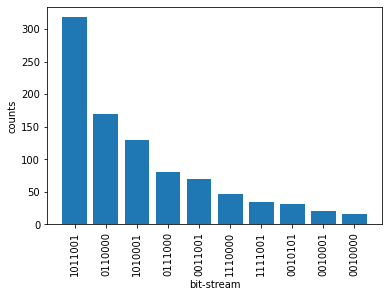

In [3]:
qh.printStats(rx, msgHat, msg, k=10)

## Showing the Quantum Hamming Decoder circuit
Now we can use Qiskit's ``draw`` method to draw the circuit. The three parts of the circuit separated by the barrier lines show the **Quantum Soft Decision**, **Quantum Generator**, and the measurement gates as explained in the paper. 

Circuit Depth: 7


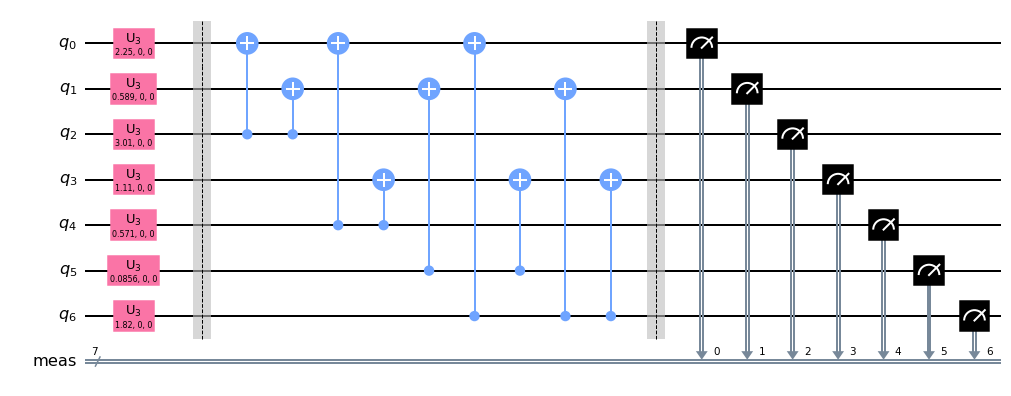

In [4]:
print("Circuit Depth:",qh.circuit.depth())
qh.circuit.decompose().decompose().draw(output='mpl')